In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sp

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, auc

from scipy import stats

from catboost import CatBoostClassifier

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [4]:
#Check du type, de la proportion de N/A et du nombre de valeurs uniques pour chaque colonne

print(f"Dataset Shape: {df.shape}") 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (70692, 22)
**Variable Description of  data:**


,index,dtypes,Missing,PercMissing,Uniques
0,Diabetes_binary,float64,0,0.0,2
1,HighBP,float64,0,0.0,2
2,HighChol,float64,0,0.0,2
3,CholCheck,float64,0,0.0,2
4,BMI,float64,0,0.0,80
5,Smoker,float64,0,0.0,2
6,Stroke,float64,0,0.0,2
7,HeartDiseaseorAttack,float64,0,0.0,2
8,PhysActivity,float64,0,0.0,2
9,Fruits,float64,0,0.0,2


In [5]:
#Colonne Target
target_column = "Diabetes_binary"

#Colonnes Numériques
numerical_columns = [
    'BMI', 'GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income'
]

#Colonnes Catégorielles
categorical_columns = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]


#On force le type pour chaque type de colonnes
for l in numerical_columns: df[l] = df[l].astype('float')
for l in categorical_columns: df[l] = df[l].astype('string').fillna("None").astype('category')
df[target_column] = df[target_column].astype('int')

#On ordonne notre df
df = df[ [target_column] + numerical_columns + categorical_columns ]

#On supprime les lignes ou la target est n/a
df = df.dropna(subset=target_column)

In [6]:
df.describe()

,Diabetes_binary,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,29.856985,2.837082,3.752037,5.810417,8.584055,4.920953,5.698311
std,0.500004,7.113954,1.113565,8.155627,10.062261,2.852153,1.029081,2.175196
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,25.000000,2.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,29.000000,3.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,33.000000,4.000000,2.000000,6.000000,11.000000,6.000000,8.000000
max,1.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


In [7]:
corr=df[numerical_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
BMI,1.000000,0.267888,0.104682,0.161862,-0.038648,-0.100233,-0.124878
GenHlth,0.267888,1.000000,0.315077,0.552757,0.155624,-0.285420,-0.382969
MentHlth,0.104682,0.315077,1.000000,0.380272,-0.101746,-0.107005,-0.219070
PhysHlth,0.161862,0.552757,0.380272,1.000000,0.084852,-0.159317,-0.279326
Age,-0.038648,0.155624,-0.101746,0.084852,1.000000,-0.107127,-0.130140
Education,-0.100233,-0.285420,-0.107005,-0.159317,-0.107127,1.000000,0.460565
Income,-0.124878,-0.382969,-0.219070,-0.279326,-0.130140,0.460565,1.000000


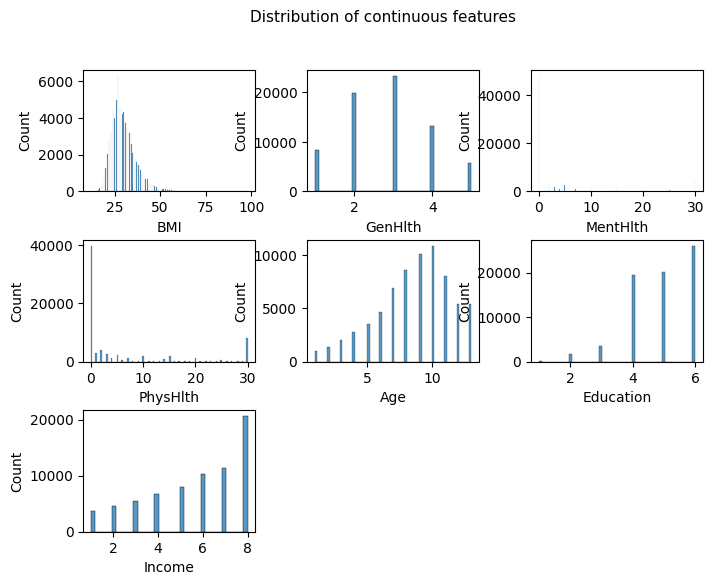

In [8]:
nb_cols=3
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of continuous features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(numerical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    sns.histplot(df[col], ax=ax)

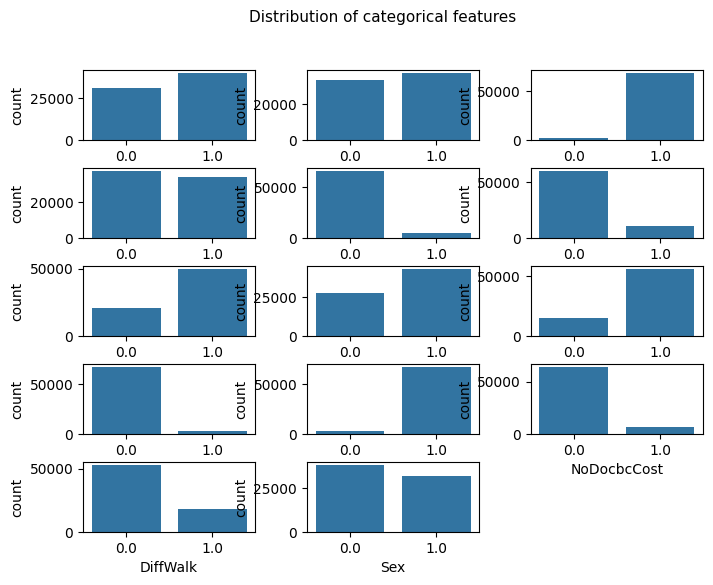

In [9]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of categorical features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(categorical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    plot = sns.countplot(df, x=col)

In [10]:
#Train/test split
 
X = df.drop(target_column, axis=1)
y = df[target_column]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
n_classes= np.unique(y).size
 
#matrice des probas
lb = LabelBinarizer().fit(y)
Y_train = lb.transform(y_train) 
Y_test = lb.transform(y_test) 
 
print("Kolmogorov p_value (train/test même distrib):", np.round(stats.ks_2samp(y_train, y_test)[1],3))
print("Shape of train X,y,Y: ",X_train.shape, y_train.shape, Y_train.shape)
print("Shape of test X,y,Y: ",X_test.shape, y_test.shape, Y_test.shape)
print("Number of classes: ", n_classes)

Kolmogorov p_value (train/test même distrib): 1.0
Shape of train X,y,Y:  (56553, 21) (56553,) (56553, 1)
Shape of test X,y,Y:  (14139, 21) (14139,) (14139, 1)
Number of classes:  2


In [11]:
#On vérifie le ratio 0/1 dans nos échantillons train et test:

Balance_train = np.unique(y_train, return_counts=True)
Prop_train = Balance_train[1]/np.sum(Balance_train[1])
 
Balance_test = np.unique(y_test, return_counts=True)
Prop_test = Balance_test[1]/np.sum(Balance_test[1])
 
print("Balance_train:", Balance_train)
print("Balance_test:", Balance_test)
print("-"*80)
print("Prop_train:", Prop_train)
print("Prop_test:", Prop_test)

Balance_train: (array([0, 1]), array([28256, 28297], dtype=int64))
Balance_test: (array([0, 1]), array([7090, 7049], dtype=int64))
--------------------------------------------------------------------------------
Prop_train: [0.49963751 0.50036249]
Prop_test: [0.50144989 0.49855011]


In [12]:
#Calibrations du seuil de décision
#CV sur 5 fold, grid search
#Le choix de la metric de validation sera le f1-score de la classe 1 afin de prendre en compte la quantité
# et la qualité des prédictions de la classe minoritaire

K_fold=5
skf = StratifiedKFold(n_splits=K_fold)
grid = np.arange(0.1,0.65,0.025)
K = np.arange(0,K_fold)

cv_result = np.zeros((K_fold, grid.size))
for (train, valid), k in zip(skf.split(X_train, y_train), K):
    clf_catboost_cv = CatBoostClassifier(loss_function="Logloss", logging_level='Silent',
                                      cat_features = categorical_columns)
    clf_catboost_cv.fit(X_train.iloc[train], y_train.iloc[train])
    y_hat = clf_catboost_cv.predict_proba(X_train.iloc[valid])
    
    for t_i in range(grid.size): cv_result[k,t_i] = f1_score(y_train.iloc[valid], (y_hat[:,1] >= grid[t_i]).astype("int"), average="macro")

threshold = grid[np.argmax(cv_result.mean(axis=0))]

print("Score atteint:", np.max(cv_result.mean(axis=0)))
print("Seuil optimal:", np.round(threshold,3))

Score atteint: 0.7505750989802411
Seuil optimal: 0.5


In [13]:
clf_catboost = CatBoostClassifier(cat_features = categorical_columns)
clf_catboost = clf_catboost.fit(X_train, y_train, verbose = False, plot=True, eval_set= (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
#Result model:

#Probabilités
Y_hat_train = clf_catboost.predict_proba(X_train)
Y_hat_test = clf_catboost.predict_proba(X_test)

#Labels
y_hat_train = Y_hat_train[:,1] >= threshold
y_hat_test = Y_hat_test[:,1] >= threshold

In [15]:
#Loss
print("Train loss: ", log_loss(Y_train, Y_hat_train))
print("Test loss: ", log_loss(Y_test, Y_hat_test))
 
print("Test loss (random): ", log_loss(Y_test, np.ones(n_test)*Prop_test[1]))

Train loss:  0.48190184445481815
Test loss:  0.49793773645471007
Test loss (random):  0.693142976189859


AUC ROC: CatBoost:  0.833 VS Random: 0.5
AUC PR: CatBoost:  0.81 VS Random: 0.499


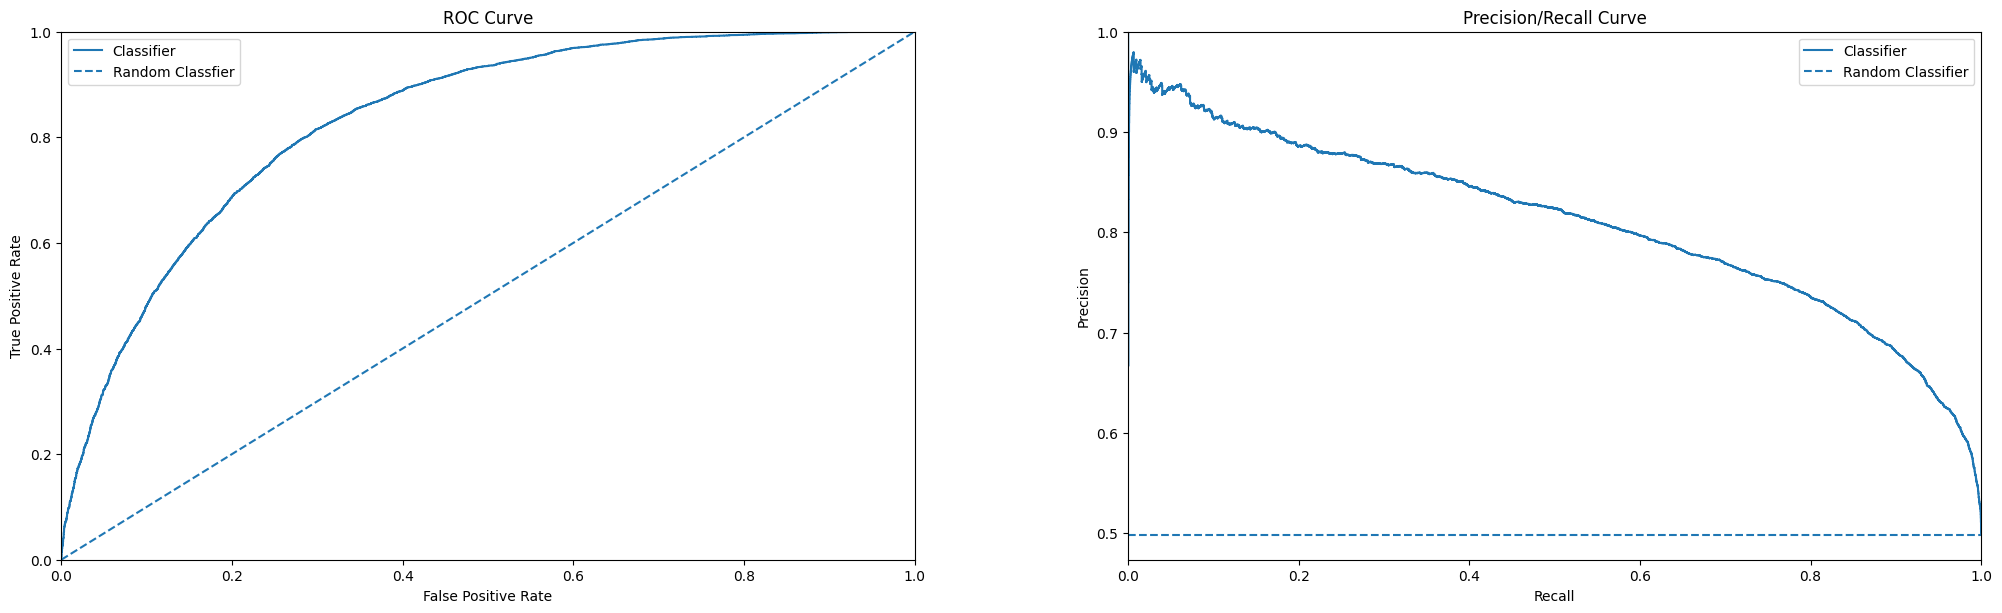

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, Y_hat_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Y_hat_test[:,1])
 
fig, (ax1, ax0) = plt.subplots(nrows=1,ncols=2)
 
PrecisionRecallDisplay(precision= precision, recall= recall).plot(ax = ax0, label = "Classifier") 
ax0.axhline(y=Prop_test[1], linestyle="--", label='Random Classifier')
ax0.legend(), ax0.set(xlim=(0, 1), ylim=(Prop_test[1]*0.95, 1), title="Precision/Recall Curve")


RocCurveDisplay(fpr= fpr, tpr= tpr).plot(ax = ax1, label = "Classifier")
ax1.axline((0, 0), slope=1, linestyle = "--", label = 'Random Classfier')
ax1.legend(), ax1.set(xlim=(0, 1), ylim=(0, 1), title="ROC Curve")

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

print("AUC ROC: CatBoost: ", np.round(auc(fpr, tpr),3), "VS Random:", 0.5)
print("AUC PR: CatBoost: ", np.round(auc(recall, precision),3), "VS Random:", np.round(Prop_test[1],3))

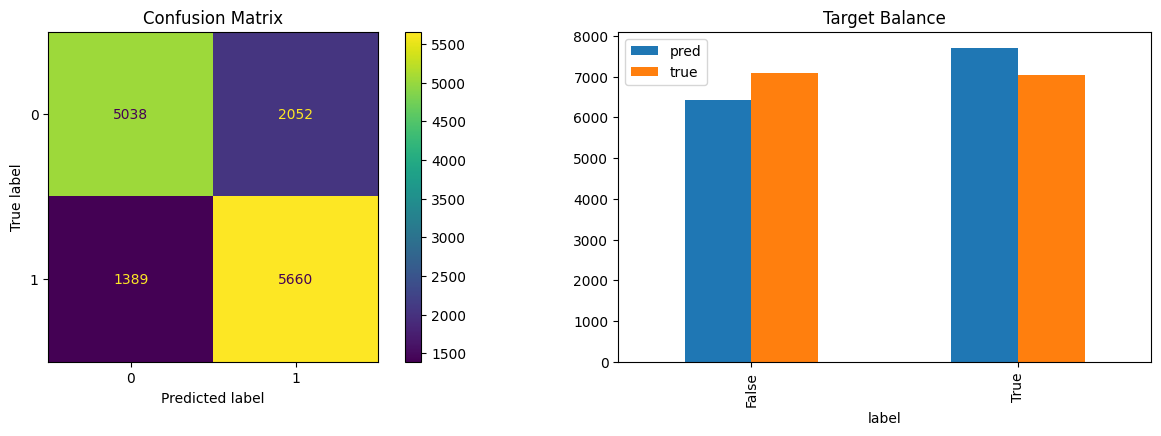

In [17]:
conf_matrix = confusion_matrix(y_test, y_hat_test)

balance = pd.DataFrame(np.unique(y_hat_test, return_counts=True), ["label", "pred"]).T.set_index("label") \
            .merge(pd.DataFrame(Balance_test, ["label", "true"]).T.set_index("label"), on="label")

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(4, 3))  # Adjust the size as needed
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = (["0", "1"]) )
cm_display.plot(ax=ax0)
ax0.set_title('Confusion Matrix')

balance.plot(ax=ax1, kind='bar')
ax1.set_title('Target Balance')

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [18]:
print(classification_report(y_test, y_hat_test, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75      7090
           1       0.73      0.80      0.77      7049

    accuracy                           0.76     14139
   macro avg       0.76      0.76      0.76     14139
weighted avg       0.76      0.76      0.76     14139



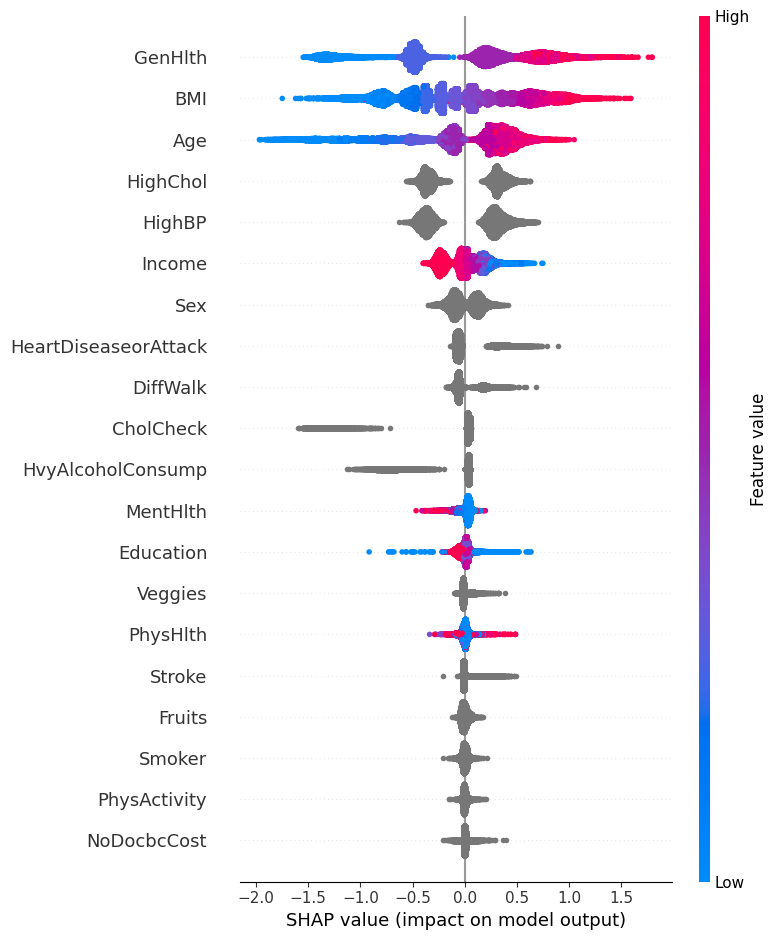

In [19]:
explainer = sp.TreeExplainer(clf_catboost)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train)